In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import urllib.request
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.') / '.czi.env'
load_dotenv(dotenv_path=env_path)


# Configure the data dir path in .czi.env located in this directory
DATA_DIR_PATH = os.environ.get("DATA_DIR_PATH")
print(f'Using data directory {DATA_DIR_PATH}')


RAW_FILE_PATH = f'{DATA_DIR_PATH}/raw.tar.gz'
LINKED_FILE_PATH = f'{DATA_DIR_PATH}/linked.tar.gz'
RAW_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822384"
LINKED_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822388"
# DISAMBIGUATED_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822387"

FILTERED_CZI_SOFTWARE_CSV = 'czi_software.csv'

def remove_empty_spaces(dic):
    """ Function removing an empty space at the first position of a string. 
    """
    for i in dic:
        if dic[i][:1] == " ":
            dic[i] = dic[i].strip()
    return dic

Using data directory ../data/czi-software-mentions


In [ ]:
# Prepare data directory and check if files exist to avoid duplicate large downloads
raw_exists = False
linked_exists = False
try:
    os.makedirs(DATA_DIR_PATH)
except FileExistsError:
    raw_exists = os.path.isfile(RAW_FILE_PATH)
    linked_exists = os.path.isfile(LINKED_FILE_PATH)

In [ ]:
# Prepare a progressbar to track download progress
import progressbar

class DownloadProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

In [ ]:
# Retrieve data from CZI dataset into data directory
if not linked_exists:
    urllib.request.urlretrieve(LINKED_TAR_URL, LINKED_FILE_PATH, DownloadProgressBar())

In [ ]:
if not raw_exists:
    urllib.request.urlretrieve(RAW_TAR_URL, RAW_FILE_PATH, DownloadProgressBar())

In [ ]:
# Extract dataset tarballs
import tarfile

with tarfile.open(RAW_FILE_PATH) as raw_tar:
    raw_tar.extractall(f'{DATA_DIR_PATH}/raw/')
with tarfile.open(LINKED_FILE_PATH) as linked_tar:
    linked_tar.extractall(f'{DATA_DIR_PATH}/linked/')

In [ ]:
# gunzip needed files
import gzip
import shutil
for gzip_file in [
    f'{DATA_DIR_PATH}/raw/raw/comm_raw.tsv.gz',
    f'{DATA_DIR_PATH}/raw/raw/non_comm_raw.tsv.gz',
    f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw.tsv.gz',
]:
    with gzip.open(gzip_file, 'rb') as f_in:
        with open(gzip_file[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [12]:
#Take a look at the data and basic cleaning
# Use dask, as we're dealing with potentially larger-than-memory data (e.g. the raw publishers mentions dataset has 10+GB)
import dask.dataframe as dd

# Read TSV into a single dataframe, brute-force mapping all values to strings
df_czi = dd.concat([
    dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/comm_raw.tsv.small', sep='\t', converters={i: str for i in range(1002)}),
    dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/non_comm_raw.tsv.small', sep='\t', converters={i: str for i in range(1002)}),
    dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw.tsv.small', sep='\t', converters={i: str for i in range(1002)})
],
ignore_index=True)

# Filter only curated software
df_filtered_czi = df_czi.loc[df_czi['curation_label'] == 'software']


['/home/stephan/src/habeas-corpus/data/czi-software-mentions/czi_software.csv']

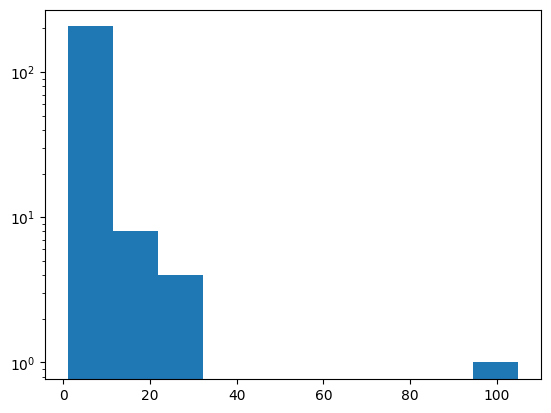

In [28]:
# Series of just the software names
software_series = df_filtered_czi.software

# A Series of unqiue value counts for the software column
software_counts = software_series.value_counts(dropna=False)

#This is what our data looks like on a log scale
plt.hist(software_counts,bins=1000)
plt.yscale('log', nonpositive='clip')

plt.savefig(f'{DATA_DIR_PATH}/czi_full_citation_histogram.png')

In [ ]:
# Save the whole humungous dataframe to a single file
df_filtered_czi.to_csv(f"{DATA_DIR_PATH}/{FILTERED_CZI_SOFTWARE_CSV}", index=False, encoding='utf-8-sig', single_file=True)

In [ ]:
# Take random sample of data, and save as CSV

SAMPLE_COUNT = 10000

i = 0
with open(f"{DATA_DIR_PATH}/{FILTERED_CZI_SOFTWARE_CSV}", 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    row_count = sum(1 for row in csv_reader)
    rand_ints = random.sample(range(1, row_count), SAMPLE_COUNT)
    with open(f"{DATA_DIR_PATH}/czi_output_random_10000.csv", 'w') as output:
        output_writer = csv.writer(output, delimiter=',')
        csv_file.seek(0)
        for row in csv_reader:
            if i == 0 or i in rand_ints:
                output_writer.writerow(row)
            i += 1
            
CZI_CSV = pd.read_csv(f"{DATA_DIR_PATH}/czi_output_random_10000.csv")
software = CZI_CSV.software

software.value_counts(dropna=False)
software_dict = software.to_dict()
software_series_sample = pd.Series(software_dict)

plt.hist(software_series_sample.value_counts(),bins=1000)
plt.yscale('log', nonpositive='clip')
plt.savefig(f'{DATA_DIR_PATH}/czi_random_10000_citation_histogram.png')

In [ ]:
#Population is non-normal so to test variances use Levene's test 
#https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm

from scipy.stats import levene
stat,p=levene(software_series.value_counts(), software_series_sample.value_counts())
print(p)
#Actual values of variances
[np.var(x, ddof=1) for x in [software_series.value_counts(), software_series_sample.value_counts()]]


with open(f'{DATA_DIR_PATH}/population_p_values', 'w') as pf:
    pf.write(f'p: {str(p)}\n{str([np.var(x, ddof=1) for x in [software_series.value_counts(), software_series_sample.value_counts()]])}')
#Gives small p-values, populations don't have equal variances (unsurprisingly...)

In [ ]:
#Can create stratified sample, here the y data are bins to split the #citations. Visually it's not so different from the fully random sample.
y=(np.linspace(0,0.999999999999,len(software_series.value_counts()))*1000).astype(np.int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(software_series.value_counts(), y,stratify=y, test_size=1000)
plt.hist(X_test, bins=1000)
plt.yscale('log', nonpositive='clip')

In [ ]:
#Does a sample look like the original (with actual tests as well as visually) if we exclude the top 100 cited?
# -> Sometimes

df_val_counts = pd.DataFrame(software.value_counts())
df_top100=df_val_counts.nlargest(100,'software')
df_without_top100=df_val_counts.nsmallest(len(df_val_counts)-100,'software')
sample_1000=df_without_top100.sample(1000)


from scipy.stats import levene
stat,p=levene(df_without_top100.software, sample_1000.software)
print(p)
#Actual values of variances
print([np.var(x, ddof=1) for x in [df_without_top100.software, sample_1000.software]])

with open(f'{DATA_DIR_PATH}/sample_p_values', 'w') as pf:
    pf.write(f'p: {str(p)}\n{str([np.var(x, ddof=1) for x in [df_without_top100.software, sample_1000.software]])}')

#Save these as our sample:

sample_1000.to_csv(f'{DATA_DIR_PATH}/CZI_sample_1000_without_top_100.csv',index=False)
df_top100.to_csv(f'{DATA_DIR_PATH}/CZI_sample_top_100.csv',index=False)




In [ ]:
# Prepare linking by reading in the mention IDs from the random sample
#import csv

#ids = []

#with open(f'{DATA_DIR_PATH}/czi_output_random_100.csv', 'r') as csvin:
#    csvr = csv.DictReader(csvin, delimiter=',')
#    for row in csvr:
#        ids.append(row['ID'])
#        # print(row)
#ids

In [ ]:
#linked_files = [
#    'bioconductor_df.csv',
#    'cran_df.csv',
#    'github_df.csv',
#    'pypi_df.csv',
#    'scicrunch_df.csv'
#]
#
#lines = []
#
#import sys
#maxInt = sys.maxsize
#
#while True:
    # decrease the maxInt value by factor 10
    # as long as the OverflowError occurs.

#    try:
#        csv.field_size_limit(maxInt)
#        break
#    except OverflowError:
#        maxInt = int(maxInt/10)

#def extract_links(lf, _id):
#    with open(f'{DATA_DIR_PATH}/linked/linked/normalized/{lf}', 'r') as csvfile:
#        datareader = csv.DictReader(csvfile)
#        for row in datareader:
#            if row['ID'] == _id:
#                yield row

#for lf in linked_files:
#    for _id in ids:
#        for huh in extract_links(lf, _id):
#            lines.append(huh)

#lines

# df = dd.read_csv("/home/stephan/src/habeas-corpus/data/czi-software-mentions/linked/linked/normalized/bioconductor_df.csv")
# print(f'EMPTY? {len(df.index)}')
# df

In [ ]:
#linked_lines = []

#with open(f'{DATA_DIR_PATH}/czi_output_random_100.csv', 'r', encoding='utf-8-sig') as csvin:
#    csvr = csv.DictReader(csvin, delimiter=',')
#    for row in csvr:
#        _id = row['ID']
#        for line in lines:
#            if line['ID'] == _id:
#                linked_line = row | line
#                linked_lines.append(linked_line)
#                continue
#        linked_lines.append(row)


In [ ]:
#import json
#
#interim_df = pd.read_json(json.dumps(linked_lines))
#interim_df.to_csv(f'{DATA_DIR_PATH}/CZI_sample_1000_without_top_100_linked.csv', encoding='utf-8', index=True)

